In [3]:
import pandas as pd
import numpy as np
import datetime as dt

from tensorflow import keras
import tensorflow as tf
from keras.utils import timeseries_dataset_from_array

import plotly.express as px
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

## Importación de datos

Leemos el archivo y ordenamos por datetime

In [4]:
data_df = pd.read_csv('data_training/predictores_modelo_pasado.csv')
data_df['Datetime_hour'] = pd.to_datetime(data_df['Datetime_hour'])
data_df['day_of_week'] = data_df['Datetime_hour'].dt.dayofweek
data_df = data_df.sort_values(by=['Datetime_hour']).reset_index(drop=True)
data_df

,Datetime_hour,Gen.PBF Nuclear,Gen.PBF Fotovoltaica,Gen.PBF Residual,MD,IDA1,IDA2,Gen.PBF Eolica,Demanda PBF,Interconexiones PBF,Gen.PBF Total,Hour,Month,Day_of_week,Precio_Gas,Precio_CO2_lag24,day_of_week
0,2024-01-02 23:00:00,7084.9,51.4,1.3,6.80,8.35,18.79,15325.5,24521.2,287.2,27841.0,0,1,2,30.75,73.17,1
1,2024-01-03 00:00:00,7084.9,51.4,1.2,3.20,3.20,6.44,14564.5,22801.2,454.3,26455.9,1,1,2,30.75,73.17,2
2,2024-01-03 01:00:00,7083.9,51.3,1.2,3.20,3.20,3.20,13479.2,21712.4,648.2,25263.2,2,1,2,30.75,73.17,2
3,2024-01-03 02:00:00,7082.9,51.3,1.1,3.20,3.20,3.20,12729.8,21147.0,834.9,24511.1,3,1,2,30.75,73.17,2
4,2024-01-03 03:00:00,7084.9,51.3,1.1,3.20,3.20,3.20,12640.5,21091.8,891.8,24399.0,4,1,2,30.75,73.17,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14442,2025-08-26 17:00:00,6797.4,7928.1,0.3,103.14,129.80,132.77,7140.8,29614.7,-2335.0,32255.7,19,8,1,33.00,71.48,1
14443,2025-08-26 18:00:00,6797.7,2051.6,0.3,117.00,127.76,136.32,7428.8,29657.2,907.9,29055.3,20,8,1,33.00,71.48,1
14444,2025-08-26 19:00:00,6798.7,38.2,0.3,123.46,122.46,130.87,7772.0,30167.2,3155.1,27318.1,21,8,1,33.00,71.48,1
14445,2025-08-26 20:00:00,6802.4,1.3,0.3,113.12,114.12,119.91,7737.2,28282.3,2154.8,26433.5,22,8,1,33.00,71.48,1


### Visualización inicial

Visualizamos la forma de la función target para las últimas 2 semanas

In [5]:
px.line(data_df.iloc[-3*24*7:], x='Datetime_hour', y='MD')

## Parte 1 - Modelo con 24 outputs

### Preparacion datos

In [155]:
def create_sequences(df, input_steps, output_steps, target_column):
    X, y = [], []
    data = df.values
    target_idx = df.columns.get_loc(target_column)

    for i in range(0, len(df) - input_steps - output_steps + 1, output_steps):
        X.append(data[i:i+input_steps, :])  # Ventana de entrada
        y.append(data[i+input_steps:i+input_steps+output_steps, target_idx])  # Ventana de salida

    return np.array(X), np.array(y)

In [174]:
### PARAMETROS
fecha_inicio = '2024-01-01'
cols_to_drop = []

val_days = 14
test_days = 14
features = [col for col in data_df.columns if col not in ['Datetime_hour']]

input_steps = 24*3
output_steps = 24

batch_size = 32

In [175]:
# Seleccionar valores
data_df = data_df.loc[data_df['Datetime_hour'] >= fecha_inicio]
data_df_clean = data_df.drop(columns=cols_to_drop)


# Número de muestras
num_test_samples = test_days * 24
num_val_samples = val_days * 24
num_train_samples = len(data_df_clean) - num_val_samples - num_test_samples
# Division en train, val y test
data_df_input = data_df_clean.drop(columns=['Datetime_hour'])
train_df = data_df_input.iloc[:num_train_samples].copy()
val_df = data_df_input.iloc[num_train_samples:num_train_samples + num_val_samples].copy()
test_df = data_df_input.iloc[num_train_samples + num_val_samples:].copy()



# Escalado de features (X)
predictors = [col for col in train_df.columns if col not in ['MD', 'Datetime_hour']]
x_scaler = StandardScaler()

train_df.loc[:, predictors] = x_scaler.fit_transform(train_df[predictors])
val_df.loc[:, predictors]   = x_scaler.transform(val_df[predictors])
test_df.loc[:, predictors]  = x_scaler.transform(test_df[predictors])


# Escalado de target (y)
y_scaler = StandardScaler()

train_df.loc[:, 'MD'] = y_scaler.fit_transform(train_df[['MD']])
val_df.loc[:, 'MD']   = y_scaler.transform(val_df[['MD']])
test_df.loc[:, 'MD']  = y_scaler.transform(test_df[['MD']])


# Ventanas temporales
X_train, y_train = create_sequences(train_df, input_steps, output_steps, 'MD')
X_val, y_val = create_sequences(val_df, input_steps, output_steps, 'MD')
X_test, y_test = create_sequences(test_df, input_steps, output_steps, 'MD')

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"Train: {y_train.shape}, Val: {y_val.shape}, Test: {y_test.shape}")

Train: (570, 72, 16), Val: (11, 72, 16), Test: (11, 72, 16)
Train: (570, 24), Val: (11, 24), Test: (11, 24)


C:\Users\jnavarro\AppData\Local\Temp\ipykernel_25496\37368772.py:22: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.66147769 -1.51701003 -1.37254238 ...  1.37234311  1.51681077
  1.66127843]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\jnavarro\AppData\Local\Temp\ipykernel_25496\37368772.py:22: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.42586539 -1.42586539 -1.42586539 ...  0.42974208  0.42974208
  0.42974208]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\jnavarro\AppData\Local\Temp\ipykernel_25496\37368772.py:22: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.49991379 -0.49991379 -0.49991379 ... -0.99993648 -0.99993648
 -0.99993648]' has dtype incompatib

### Modelo LSTM

In [169]:
### PARAMETROS
dropout = 0.2
n_neurons = 64
r_drop = 0.25
patience = 10
lr = 0.0005
n_epochs = 50
regularizer = keras.regularizers.l2(1e-4)

In [170]:
inputs = keras.Input(shape=(input_steps, X_train.shape[-1]))
x = keras.layers.LSTM(n_neurons, recurrent_dropout=r_drop, activation='tanh', return_sequences=True, kernel_regularizer=regularizer)(inputs)
x = keras.layers.Dropout(dropout)(x)
x = keras.layers.LSTM(n_neurons, recurrent_dropout=r_drop, activation='tanh', return_sequences=False, kernel_regularizer=regularizer)(x)
x = keras.layers.Dropout(dropout)(x)
outputs = keras.layers.Dense(output_steps)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
]

optimizer = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
history = model.fit(X_train, y_train,
                    epochs=n_epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.8682 - mae: 0.7947 - val_loss: 0.6361 - val_mae: 0.6928
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.5857 - mae: 0.6231 - val_loss: 0.4407 - val_mae: 0.5510
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.4258 - mae: 0.5101 - val_loss: 0.3290 - val_mae: 0.4598
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.3707 - mae: 0.4720 - val_loss: 0.3005 - val_mae: 0.4319
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.3366 - mae: 0.4425 - val_loss: 0.2713 - val_mae: 0.4082
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.3153 - mae: 0.4264 - val_loss: 0.2653 - val_mae: 0.3973
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.3000 - mae: 0.4136 - val_loss: 0.2748 - val_mae: 0.4019
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.2990 - mae: 0.4104 - val_loss: 0.2578 - val_mae: 0.3879
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.271

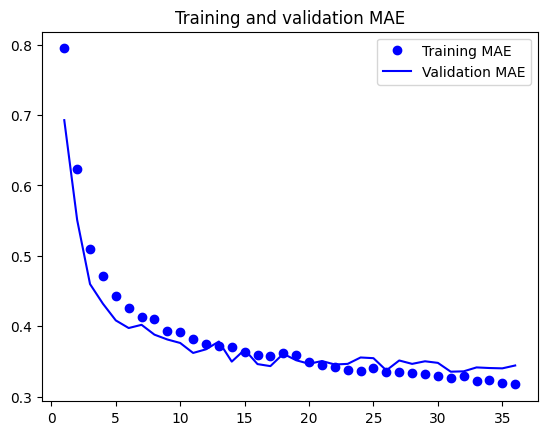

In [172]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Evaluación y resultados

In [173]:
model = keras.models.load_model("jena_lstm_dropout.keras")
y_pred = model.predict(X_test)

y_pred_rescaled = y_scaler.inverse_transform(y_pred)
y_test_rescaled = y_scaler.inverse_transform(y_test)


rmse = np.sqrt(mean_squared_error(y_test_rescaled.flatten(), y_pred_rescaled.flatten()))
mae  = mean_absolute_error(y_test_rescaled.flatten(), y_pred_rescaled.flatten())

print(f"RMSE: {rmse:.3f}")
print(f"MAE : {mae:.3f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
RMSE: 19.883
MAE : 14.801


## Parte 2: 1 output step y forecast iterativo

### Preparación de datos

In [111]:
def create_sequences_single_step(df, input_steps, target_column, step=1):
    X, y = [], []
    data = df.values
    target_idx = df.columns.get_loc(target_column)

    for i in range(0, len(df) - input_steps, step):
        X.append(data[i:i+input_steps, :])             # Ventana de entrada
        y.append(data[i+input_steps, target_idx])      # Solo 1 paso hacia adelante

    return np.array(X), np.array(y).reshape(-1, 1)

In [112]:
output_steps = 1

# Seleccionar valores
data_df = data_df.loc[data_df['Datetime_hour'] >= fecha_inicio]
data_df_clean = data_df.drop(columns=cols_to_drop)


# Número de muestras
num_test_samples = test_days * 24
num_val_samples = val_days * 24
num_train_samples = len(data_df_clean) - num_val_samples - num_test_samples
# Division en train, val y test
data_df_input = data_df_clean.drop(columns=['Datetime_hour'])
train_df = data_df_input.iloc[:num_train_samples].copy()
val_df = data_df_input.iloc[num_train_samples:num_train_samples + num_val_samples].copy()
test_df = data_df_input.iloc[num_train_samples + num_val_samples:].copy()



# Escalado de features (X)
predictors = [col for col in train_df.columns if col not in ['MD', 'Datetime_hour']]
x_scaler = StandardScaler()

train_df.loc[:, predictors] = x_scaler.fit_transform(train_df[predictors])
val_df.loc[:, predictors]   = x_scaler.transform(val_df[predictors])
test_df.loc[:, predictors]  = x_scaler.transform(test_df[predictors])


# Escalado de target (y)
y_scaler = StandardScaler()

train_df.loc[:, 'MD'] = y_scaler.fit_transform(train_df[['MD']])
val_df.loc[:, 'MD']   = y_scaler.transform(val_df[['MD']])
test_df.loc[:, 'MD']  = y_scaler.transform(test_df[['MD']])


# Ventanas temporales
X_train, y_train = create_sequences_single_step(train_df, input_steps, 'MD')
X_val, y_val = create_sequences_single_step(val_df, input_steps, 'MD')
X_test, y_test = create_sequences_single_step(test_df, input_steps, 'MD')

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"Train: {y_train.shape}, Val: {y_val.shape}, Test: {y_test.shape}")

Train: (13607, 168, 16), Val: (168, 168, 16), Test: (168, 168, 16)
Train: (13607, 1), Val: (168, 1), Test: (168, 1)


C:\Users\jnavarro\AppData\Local\Temp\ipykernel_25496\3837597256.py:24: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.66147769 -1.51701003 -1.37254238 ...  1.37234311  1.51681077
  1.66127843]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\jnavarro\AppData\Local\Temp\ipykernel_25496\3837597256.py:24: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.42586539 -1.42586539 -1.42586539 ...  0.42974208  0.42974208
  0.42974208]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\jnavarro\AppData\Local\Temp\ipykernel_25496\3837597256.py:24: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.49991379 -0.49991379 -0.49991379 ... -0.99993648 -0.99993648
 -0.99993648]' has dtype inco

## Calculo del error base

Tenemos que establecer un objetivo de precisión para nuestro modelo. Para ello, suponemos dos pronósticos iniciales:
1. El precio a la misma hora del día anterior
2. El precio a la misma hora y el mismo día de la semana anterior

Consideramos esta segunda posibilidad, debido a la gran diferencia que existe entre los precios en fin de semana y entre semana.

In [104]:
md_true = []
md_delay_day = []
data_array = data_df_input.values

# Calculamos los targets para el dataset sin escalar
for i in range(len(data_array) - input_steps - output_steps):
    md_true.append(data_array[i+input_steps:i+input_steps+output_steps, features.index('MD')])
    # Delay de 1 dia
    md_delay_day.append(data_array[i+input_steps-24:i+input_steps+output_steps-24, features.index('MD')])


md_true = np.array(md_true)
md_delay_day = np.array(md_delay_day)

print(f"MAE day-delay: {np.mean(np.abs(md_true - md_delay_day))}")

MAE day-delay: 19.62972358578775


Evolución del entrenamiento

In [99]:
y_pred_rescaled.shape

(923, 24)